In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/philip/DIKU/bachelor_project/


### Imports

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.plot_tools import plot_roc
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps

### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


# Tinyimagenet

### FN

#### FGSM with varying epsilon values

In [11]:
eps, roc_stats = load_and_eval_mls_osr_for_all_eps(root_dir + 'logits/tinyimagenet/fn/fgsm/', 0, dataset_name='tinyimagenet')
aurocs = [x[1] for x in roc_stats]

In [19]:
eps

[0.020000000000000004,
 0.030889042098927583,
 0.04770664608946602,
 0.07368062997280773,
 0.11379620405527817,
 0.17575278688808205,
 0.2714417616594907,
 0.4192288001653537]

Text(0, 0.5, 'AUROC')

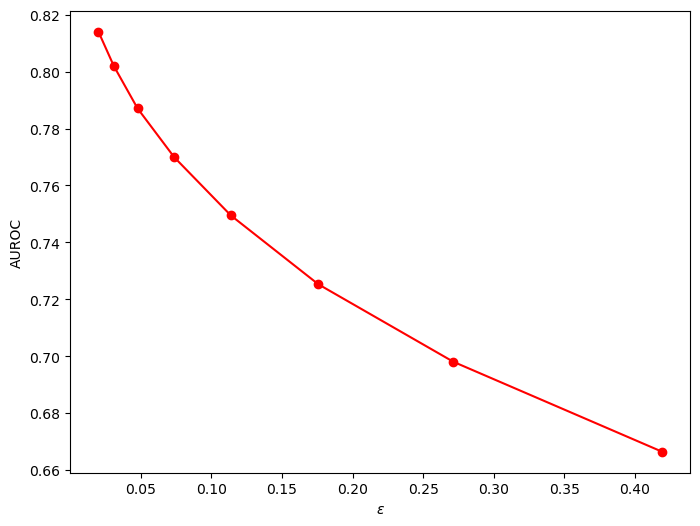

In [49]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(eps, aurocs, c='red')
ax.scatter(eps, aurocs, c='red')
ax.set_xlabel('$\\epsilon$')
ax.set_ylabel('AUROC')
# fig.legend()

In [27]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet')
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_fn = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fn/fgsm/eps_0.4192288001653537/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/fn/fgsm/eps_0.4192288001653537/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet')

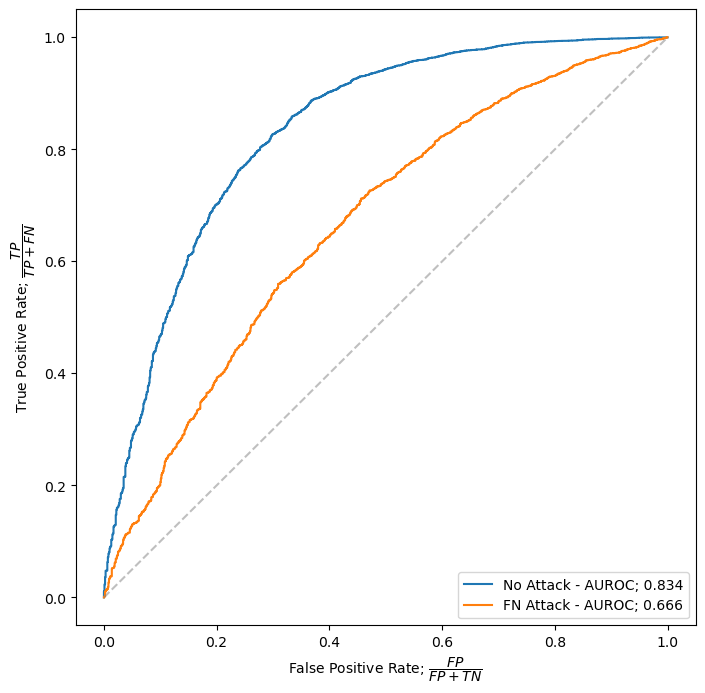

In [42]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_fn[0], label=f'FN Attack - AUROC; {roc_stats_fn[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='lower right')
plt.show()